In [38]:
# import the libraries 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# lets load the datafile 
data = pd.read_csv('Country-data.csv')

In [3]:
data.shape

(167, 10)

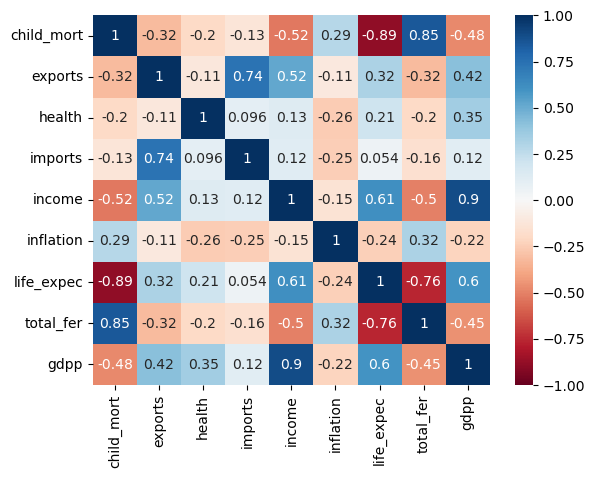

In [4]:
# correlation map 
sns.heatmap(data.corr(numeric_only=True),annot=True,cmap='RdBu',vmin=-1)
plt.show()

## Visualize the Data

In [5]:
# before we begin visulaization lets convert country to index 

data.set_index('country',inplace=True)
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


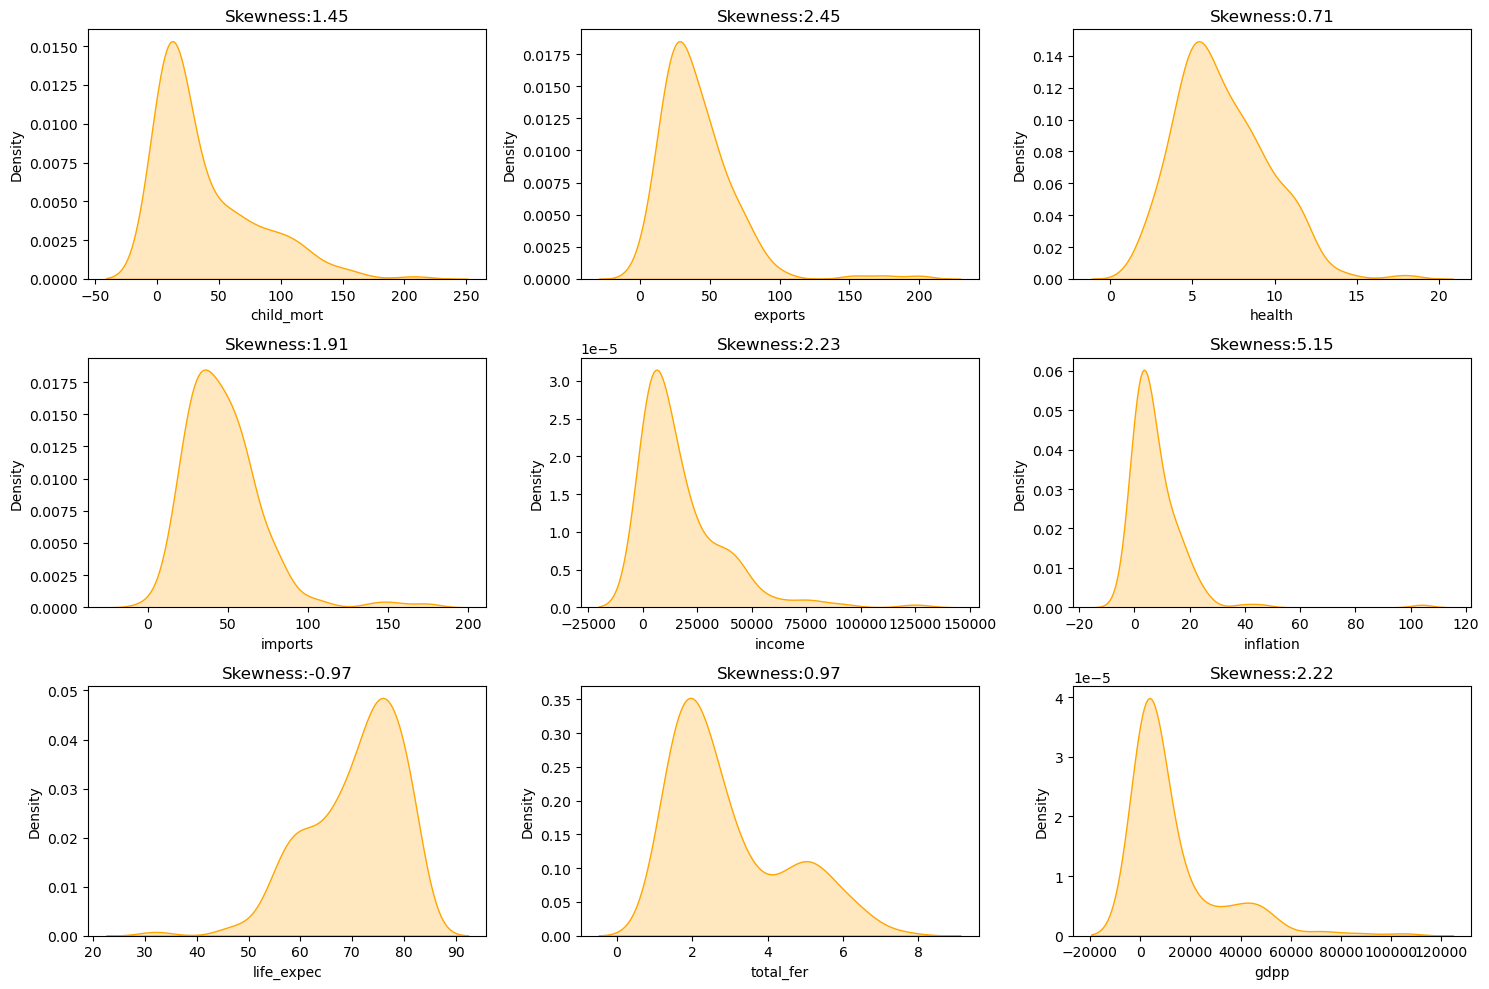

In [6]:
# Univariate Analysis 

t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.kdeplot(data=data,x=i,fill=True,color='orange')
    plt.title(f'Skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

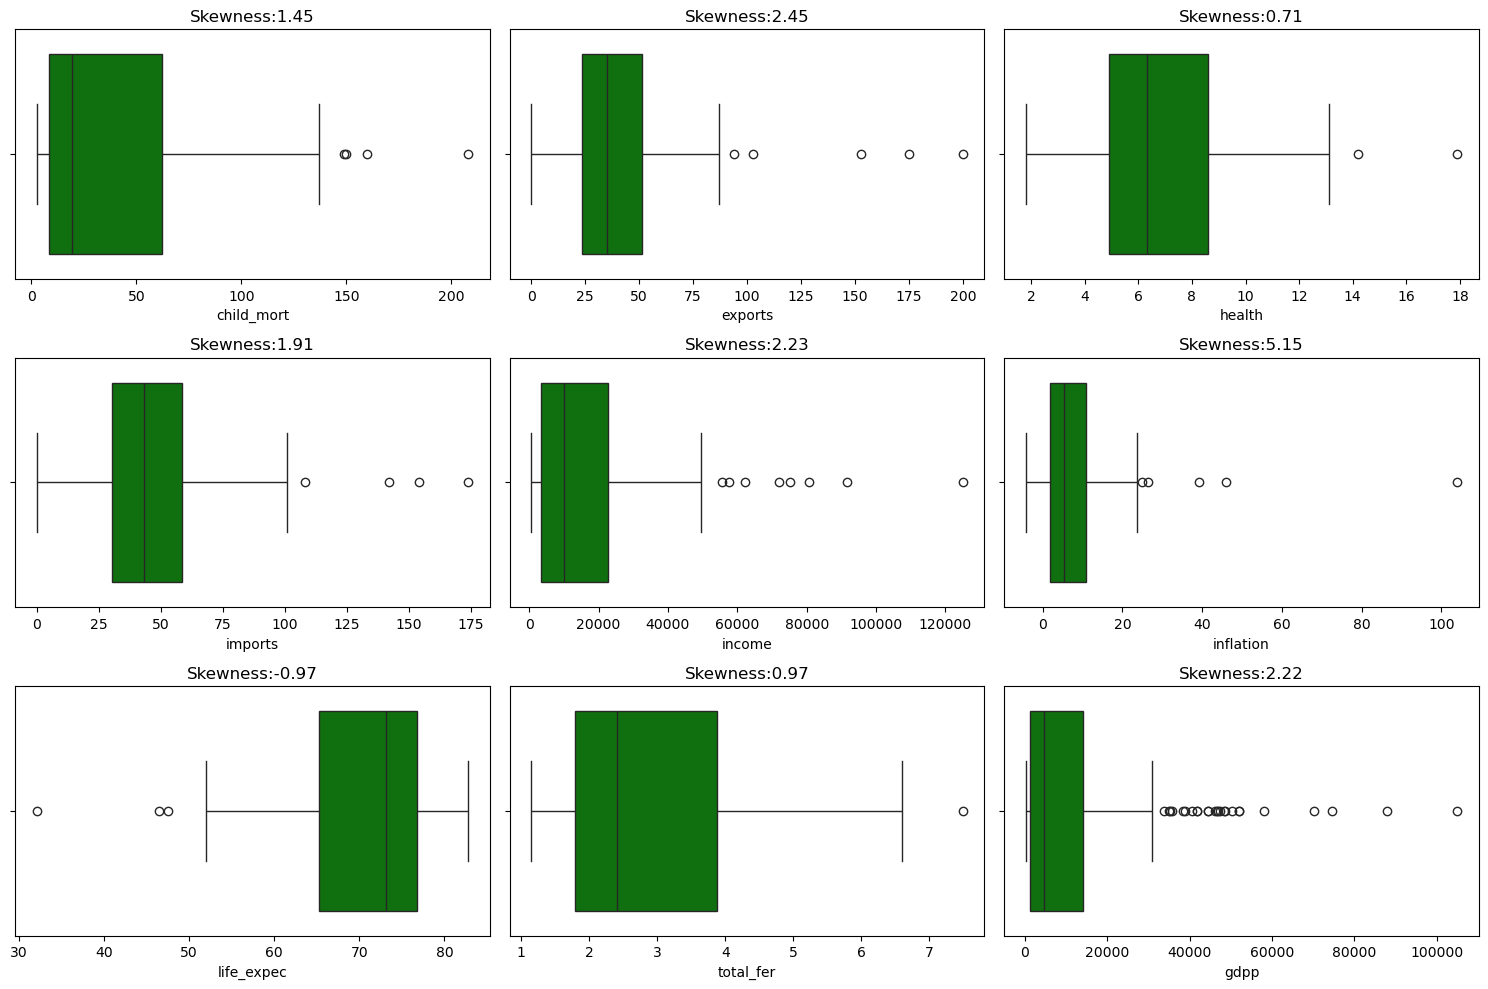

In [7]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,color='green')
    plt.title(f'Skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

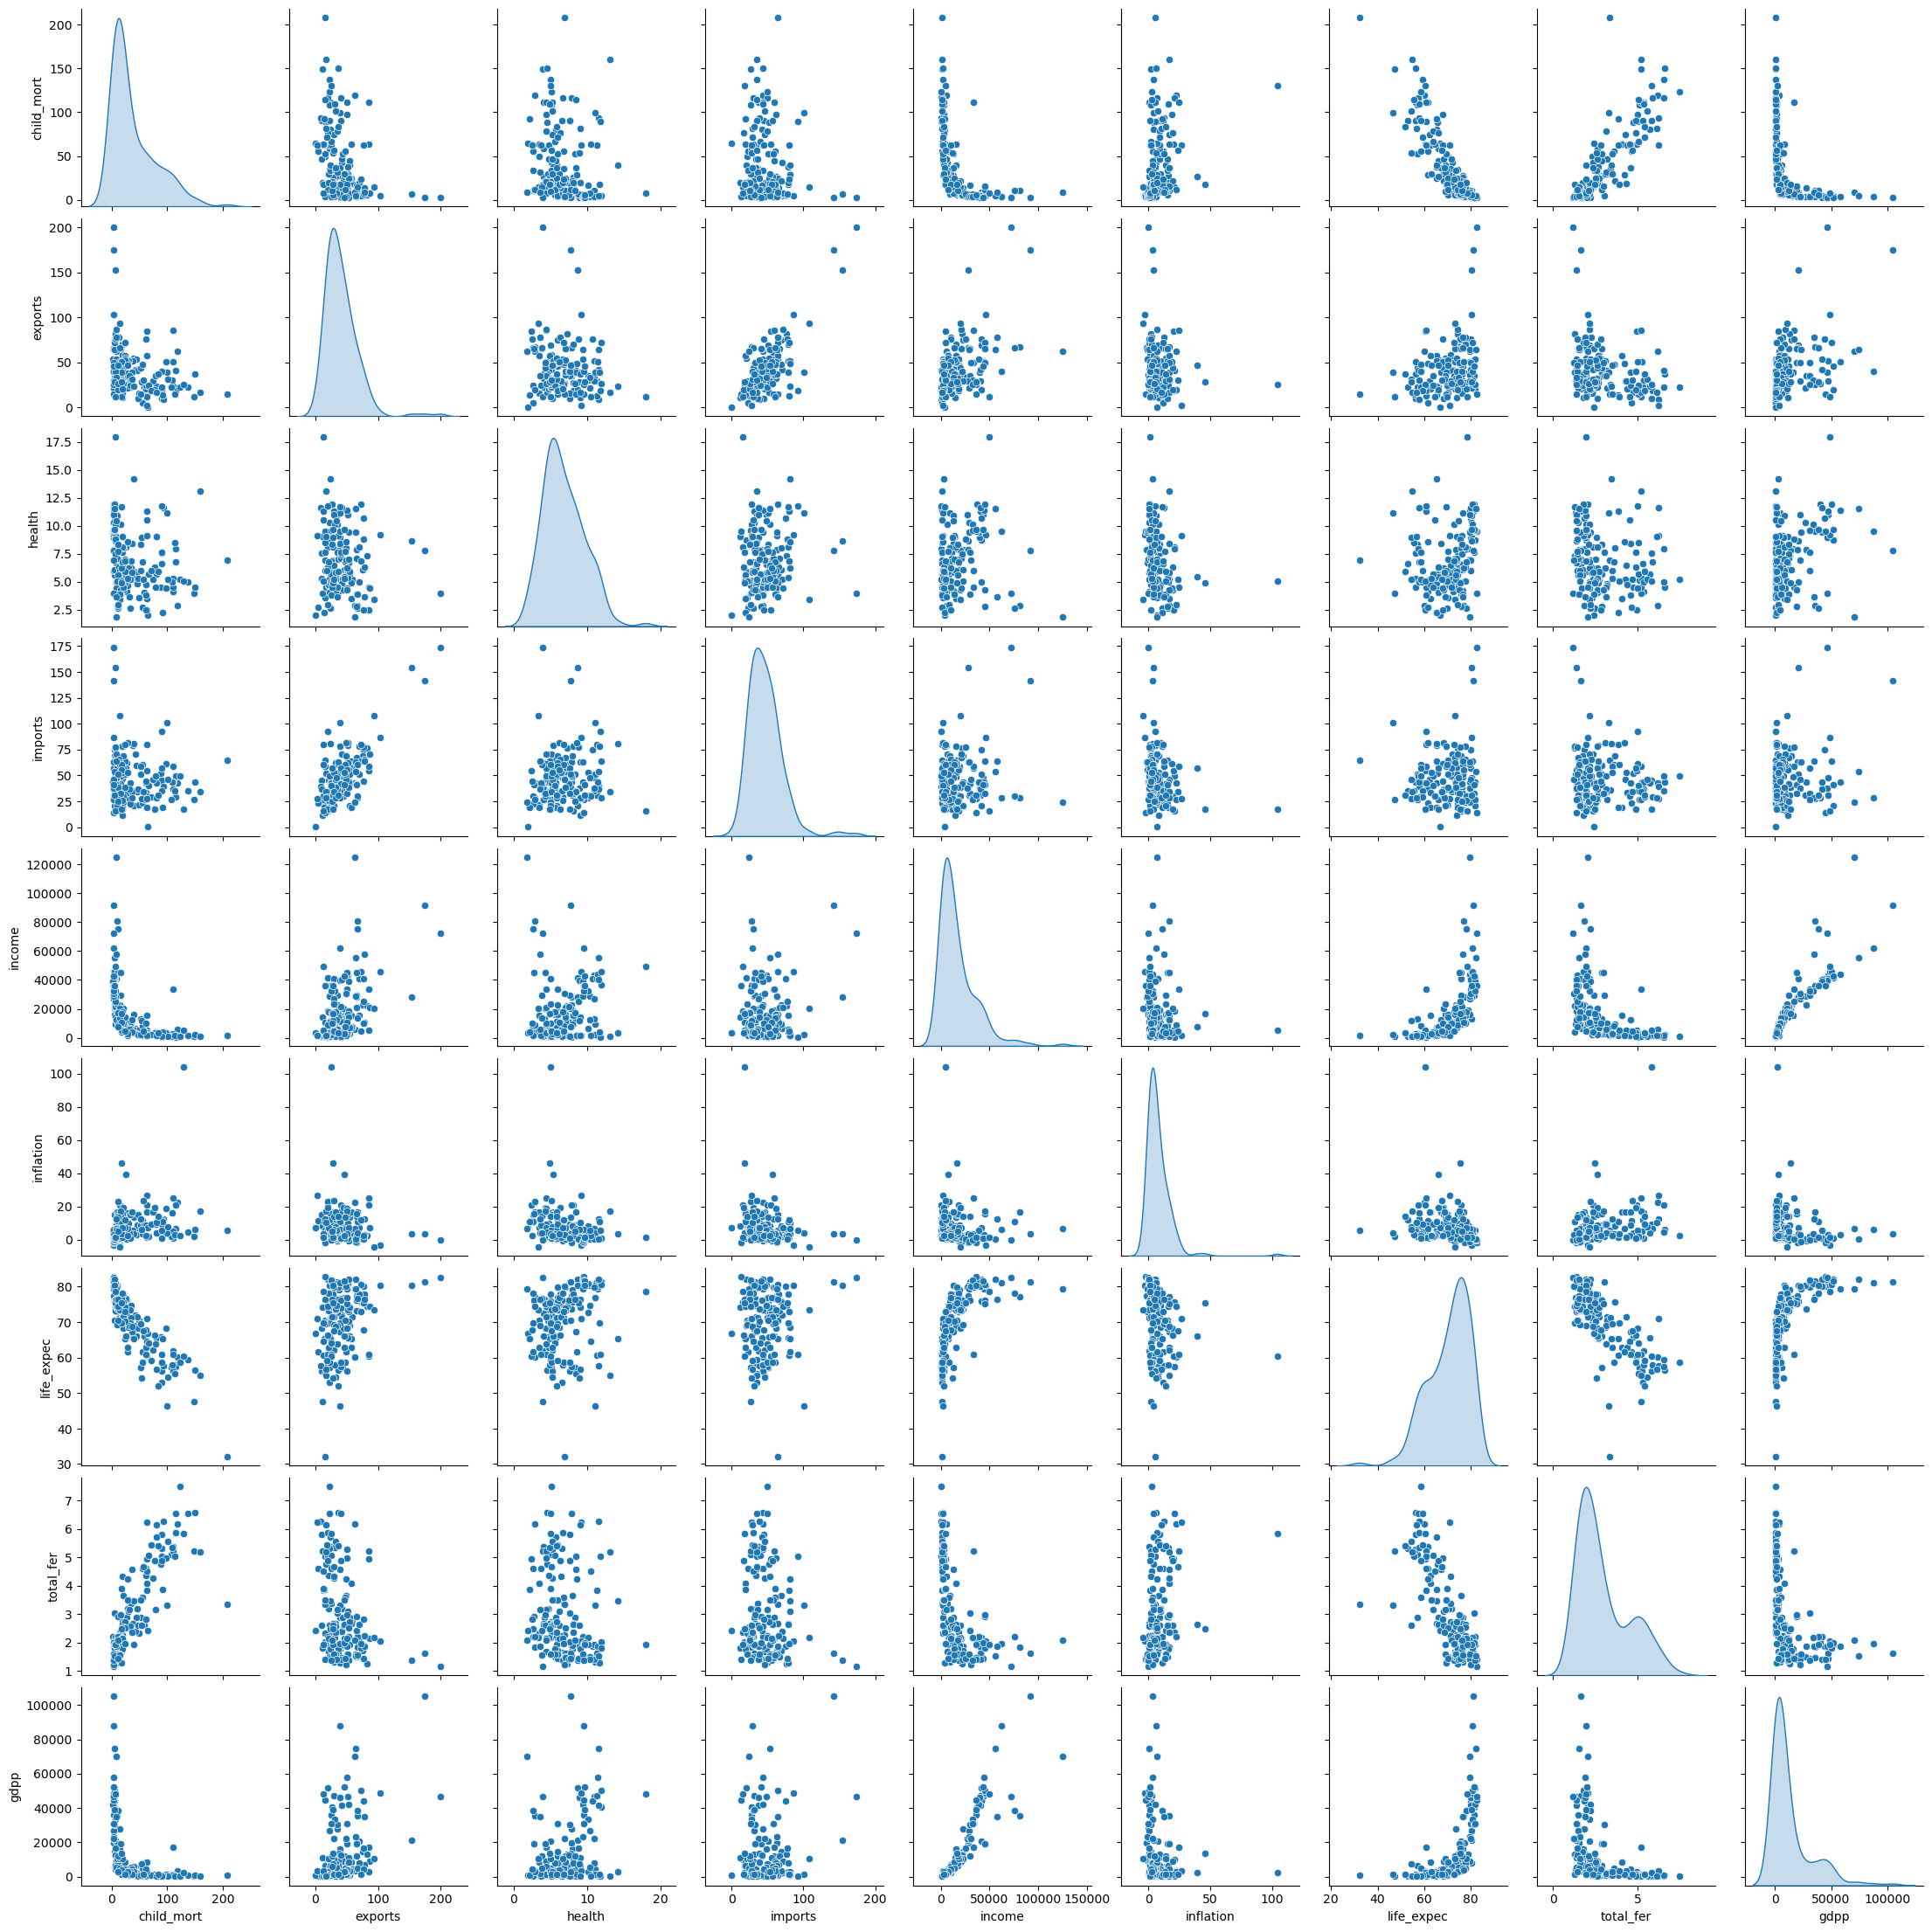

In [9]:
# multivariate Analysis
sns.pairplot(data,diag_kind='kde')
plt.show()

### Preprocessing 

In [11]:
# Check for missing values 
data.isnull().sum().sum()

# no missing values 

np.int64(0)

In [12]:
# Lets treat the extreme outliers 
# we will go with capping using IQR method
# In order to cap only the extreme ones lets keep whisker length = 2.5

for i in data.columns:
    q1,q3 = np.quantile(data[i],[0.25,0.75])
    iqr = q3 - q1
    ul,ll = q3+2.5*iqr,q1-2.5*iqr
    data[i] = data[i].apply(lambda x: ul if x>ul else ll if x<ll else x)

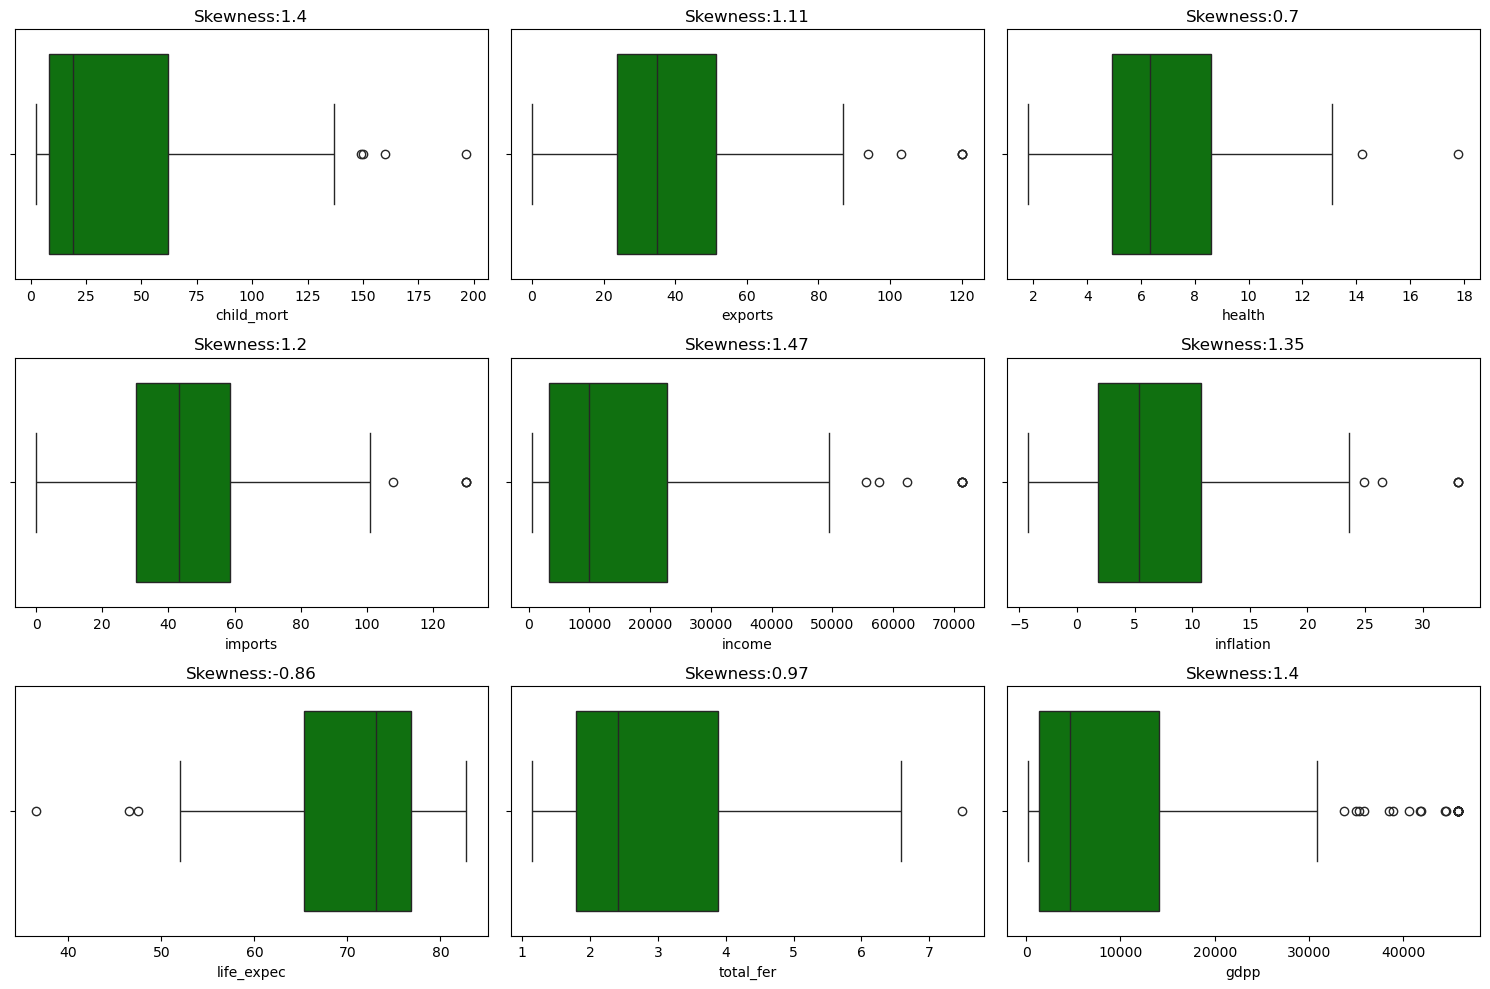

In [13]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,color='green')
    plt.title(f'Skewness:{round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [ ]:
# lets apply PCA on the data before we proceed with clustering. Just to have better visualization and better clustering.
# In PCA we need to pass the standardized data. So lets import the required libraries.

# data --> standardize --> PCA --> data_PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [20]:
# Lets create and instance of scalliung

scaler = StandardScaler()

# Also create an instance for PCA 
pca = PCA(n_components=5,random_state=2)

# Lets create pipeline for the above two process

pipeline = Pipeline([('Scale',scaler),
                     ('PCA',pca)])

In [21]:
pipeline.fit(data)

Pipeline(steps=[('Scale', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=2))])

In [22]:
pca.explained_variance_

array([4.30850704, 1.51337327, 1.22641085, 0.92104999, 0.60026658])

In [23]:
pca.explained_variance_ratio_.cumsum()

# At n_components = 5 we are able to explain ~ 95% variance  , which is good enough.
# So 9-dimension data can be reduces to 5-Dimension

array([0.4758564 , 0.64300208, 0.77845398, 0.88018006, 0.94647697])

In [32]:
final_data = pipeline.transform(data)

In [33]:
final_data

array([[-3.04363665e+00, -2.01155292e-01,  9.51322351e-01,
         7.93444721e-01, -6.80001185e-03],
       [ 4.23415208e-01, -3.71462539e-01,  1.71749065e-01,
        -1.35358051e+00,  8.86229412e-02],
       [-4.04683884e-01, -4.40311949e-01, -1.63677511e+00,
        -5.73008378e-01,  3.97118511e-01],
       [-3.15006302e+00,  1.42528284e+00, -1.78498242e+00,
         1.58007124e+00,  1.42608744e-01],
       [ 1.14531297e+00,  3.92984506e-01,  1.51331589e-01,
        -8.23192552e-01, -3.70310799e-01],
       [-9.54170948e-02, -1.94085770e+00, -1.22199962e+00,
        -6.97940551e-03,  1.46093189e+00],
       [-1.77388617e-01, -4.27355752e-01, -5.02299598e-01,
        -1.52366162e+00, -7.48969680e-02],
       [ 2.60291028e+00, -2.23430488e+00,  1.85775655e-01,
         9.24552024e-01, -8.08426394e-01],
       [ 3.37172117e+00, -7.27160920e-01,  7.98543302e-01,
         1.21431820e+00, -2.41834808e-02],
       [-2.30117700e-01, -3.71196507e-01, -1.22883809e+00,
        -1.91571536e-01

In [34]:
# Transform return trhe array . Lets convert it into the DataFrame 
final_data = pd.DataFrame(final_data,columns=['PC1','PC2','PC3','PC4','PC5'],
                          index=data.index)
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119


## K-Means Clustering 

In [35]:
# lets import the required libraries first 

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

In [44]:
# Identify the value of k 

# KElbow Visulaizer 

Kelbow = KElbowVisualizer(estimator=KMeans(random_state=2),k=10)

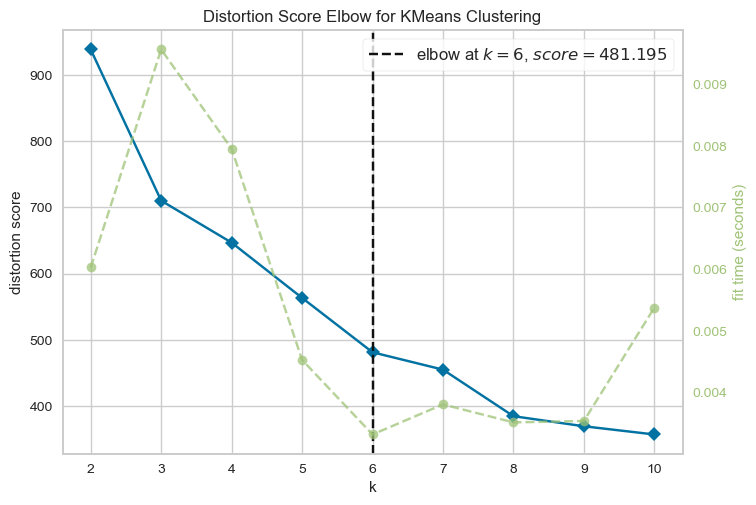

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
Kelbow.fit(final_data)
Kelbow.show()